### Question 2:
Please describe at least two ways of ensembling together DNNs and RFs. Take any dataset from Kaggle and (1) train an RF model, (2) train a DNN, and (3) a hybrid DNN and RF model. Provide detailed model and result comparisons. 

https://www.kaggle.com/ronitf/heart-disease-uci

age

sex

chest pain type (4 values)

resting blood pressure

serum cholestoral in mg/dl

fasting blood sugar > 120 mg/dl

resting electrocardiographic results (values 0,1,2)

maximum heart rate achieved

exercise induced angina

oldpeak = ST depression induced by exercise relative to rest

the slope of the peak exercise ST segment

number of major vessels (0-3) colored by flourosopy

thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,matthews_corrcoef,f1_score,classification_report,roc_curve,roc_auc_score,confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('./YongjiShen_heart.csv')
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Pre-cleaning dataset

In [3]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
df.shape

(303, 14)

In [5]:
y = df["target"]
x = df.drop("target",axis = 1)

In [6]:
print(x.shape, y.shape)

(303, 13) (303,)


In [10]:
conclusion = dict()

### Train an RF model

In [11]:
x_train_valid,x_test,y_train_valid,y_test=train_test_split(x,y,test_size=0.15)
x_train,x_valid,y_train,y_valid=train_test_split(x_train_valid,y_train_valid,test_size=x_test.shape[0]/x_train_valid.shape[0])
print(x_train.shape, x_valid.shape,x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1) 
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
print(x_train.shape,y_train.shape)

(211, 13) (46, 13) (46, 13)
(211,) (46,) (46,)
(234, 13) (234,)


In [12]:
rf1_test_result =dict()
for i in range(1,101,10):
    rf_test_1 = RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = i)
    rf_test_1.fit(x_train,y_train)
    y_pred = rf_test_1.predict(x_valid)
    rf1_test_result[i]=accuracy_score(y_valid,y_pred)

In [13]:
result_df = pd.DataFrame(list(rf1_test_result.items()),columns = ['n_estimators', 'accuracy'])

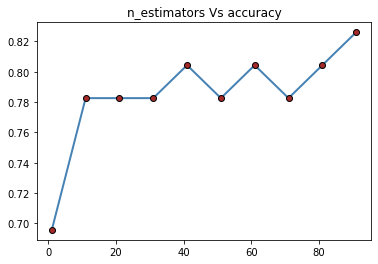

In [14]:
plt.title("n_estimators Vs accuracy")
plt.plot(result_df.n_estimators,result_df.accuracy,linestyle = '-',linewidth = 2, color = 'steelblue',marker = 'o',markersize = 6, markeredgecolor='black', markerfacecolor='brown') 

In [15]:
sorted_dict = sorted(rf1_test_result.items(), key=lambda x: x[1], reverse=True)

In [16]:
rf_1 = RandomForestClassifier(n_jobs = -1, n_estimators = sorted_dict[0][0],bootstrap = True)
rf_1.fit(x_train,y_train)

RandomForestClassifier(n_estimators=91, n_jobs=-1)

In [17]:
y_pred = rf_1.predict(x_test)

In [18]:
accuracy_score(y_pred, y_test)

0.8478260869565217

In [19]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.89      0.86      0.87        28

    accuracy                           0.85        46
   macro avg       0.84      0.85      0.84        46
weighted avg       0.85      0.85      0.85        46



Text(50.99999999999999, 0.5, 'Predicted')

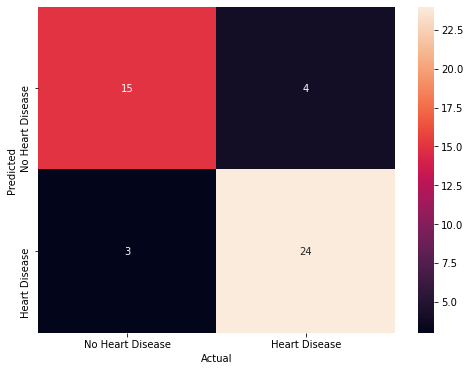

In [20]:
c_mat = confusion_matrix(y_pred, y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["No Heart Disease","Heart Disease"]
c_mat_df.index = ["No Heart Disease","Heart Disease"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

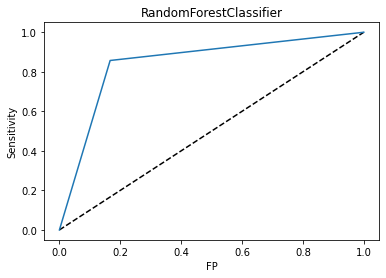

In [21]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
title = "RandomForestClassifier"
plt.title(title)
plt.show()

In [22]:
roc_auc_score(y_pred, y_test)

0.8452380952380952

In [23]:
conclusion["RandomForestClassifier()"]=accuracy_score(y_pred, y_test)

### Train a DNN model

In [90]:
x_train_valid,x_test,y_train_valid,y_test=train_test_split(x,y,test_size=0.15)
x_train,x_valid,y_train,y_valid=train_test_split(x_train_valid,y_train_valid,test_size=x_test.shape[0]/x_train_valid.shape[0])
print(x_train.shape, x_valid.shape,x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1) 
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
print(x_train.shape,y_train.shape)

(211, 13) (46, 13) (46, 13)
(211,) (46,) (46,)
(240, 13) (240,)


In [91]:
model = Sequential()
model.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
model_history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),epochs=20, batch_size=5)

Epoch 1/20
48/48 [==============================] - 0s 2ms/step - loss: 6.4841 - accuracy: 0.5750 - val_loss: 1.3777 - val_accuracy: 0.6522
Epoch 2/20
48/48 [==============================] - 0s 831us/step - loss: 1.0904 - accuracy: 0.7000 - val_loss: 0.8684 - val_accuracy: 0.7391
Epoch 3/20
48/48 [==============================] - 0s 832us/step - loss: 0.8288 - accuracy: 0.6583 - val_loss: 1.0596 - val_accuracy: 0.6304
Epoch 4/20
48/48 [==============================] - 0s 810us/step - loss: 0.8084 - accuracy: 0.6625 - val_loss: 0.9039 - val_accuracy: 0.6739
Epoch 5/20
48/48 [==============================] - 0s 790us/step - loss: 0.6579 - accuracy: 0.7208 - val_loss: 0.7453 - val_accuracy: 0.6957
Epoch 6/20
48/48 [==============================] - 0s 834us/step - loss: 0.6622 - accuracy: 0.7042 - val_loss: 0.7968 - val_accuracy: 0.6957
Epoch 7/20
48/48 [==============================] - 0s 873us/step - loss: 0.6315 - accuracy: 0.6917 - val_loss: 0.6225 - val_accuracy: 0.7391
Epoch 8/

In [93]:
his_df = pd.DataFrame (model_history.history)
his_df.reset_index(inplace=True)
his_df.head()

,index,loss,accuracy,val_loss,val_accuracy
0,0,6.484144,0.575000,1.377667,0.652174
1,1,1.090389,0.700000,0.868434,0.739130
2,2,0.828800,0.658333,1.059558,0.630435
3,3,0.808448,0.662500,0.903916,0.673913
4,4,0.657872,0.720833,0.745322,0.695652


<AxesSubplot:>

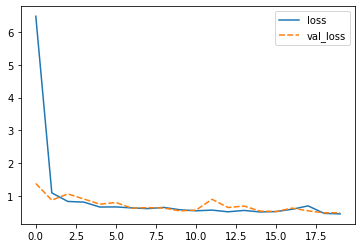

In [94]:
sns.lineplot(data=(his_df["loss"],his_df["val_loss"]))

<AxesSubplot:>

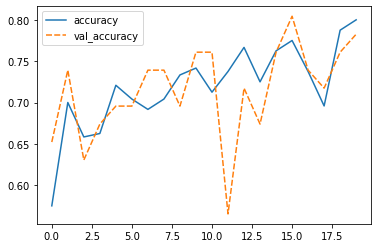

In [95]:
sns.lineplot(data=(his_df["accuracy"],his_df["val_accuracy"]))

In [96]:
acc = model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 997us/step - loss: 0.4803 - accuracy: 0.6957


In [97]:
y_test_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.55      0.75      0.63        16

    accuracy                           0.70        46
   macro avg       0.69      0.71      0.69        46
weighted avg       0.73      0.70      0.70        46



Text(50.99999999999999, 0.5, 'Predicted')

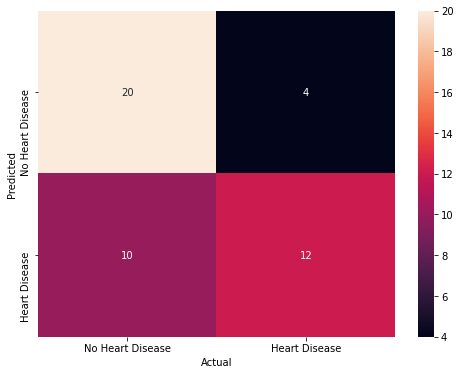

In [98]:
c_mat = confusion_matrix(y_test, y_test_pred)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["No Heart Disease","Heart Disease"]
c_mat_df.index = ["No Heart Disease","Heart Disease"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

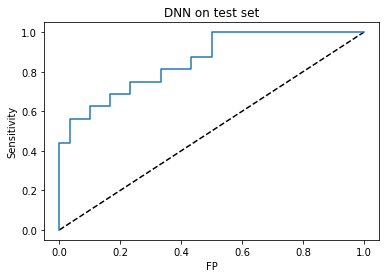

In [99]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='DNN')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('DNN on test set')
plt.show()

In [100]:
roc_auc_score(y_test, y_test_pred)

0.7083333333333334

In [101]:
conclusion["DNN - Sequential()"]=acc[1]

### 3.Ways of ensembling together DNNs and RFs

#### 1. Stacking

In [36]:
x_train_valid,x_test,y_train_valid,y_test=train_test_split(x,y,test_size=0.15)
x_train,x_valid,y_train,y_valid=train_test_split(x_train_valid,y_train_valid,test_size=x_test.shape[0]/x_train_valid.shape[0])
print(x_train.shape, x_valid.shape,x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1) 
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
print(x_train.shape,y_train.shape)

(211, 13) (46, 13) (46, 13)
(211,) (46,) (46,)
(234, 13) (234,)


In [37]:
def create_model():
    model = Sequential()
    model.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [38]:
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
model._estimator_type = "classifier"

In [39]:
estimators = [('dnn',  model)]
sclf_test_test_result =dict()
for i in range(1,101,10):
    sclf_test = StackingClassifier(estimators= estimators , 
                          final_estimator=RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = i)
                         )
    sclf_test.fit(x_train,y_train)
    y_pred = sclf_test.predict(x_valid)
    sclf_test_test_result[i]=accuracy_score(y_valid,y_pred)

Instructions for updating:
Please use `model.predict()` instead.


In [40]:
sclf_result_df = pd.DataFrame(list(sclf_test_test_result.items()),columns = ['n_estimators', 'accuracy'])

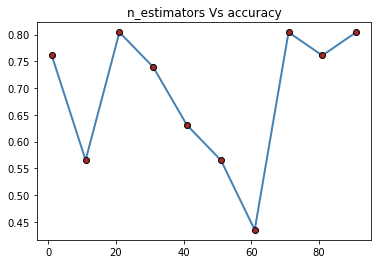

In [41]:
plt.title("n_estimators Vs accuracy")
plt.plot(sclf_result_df.n_estimators,sclf_result_df.accuracy,linestyle = '-',linewidth = 2, color = 'steelblue',marker = 'o',markersize = 6, markeredgecolor='black', markerfacecolor='brown') 

In [42]:
sclf_sorted_dict = sorted(sclf_test_test_result.items(), key=lambda x: x[1], reverse=True)

In [43]:
sclf = StackingClassifier(estimators= estimators , 
                          final_estimator=RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = sclf_sorted_dict[0][0])
                         )

In [44]:
sclf.fit(x_train,y_train)

StackingClassifier(estimators=[('dnn',
                                <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000249722813C8>)],
                   final_estimator=RandomForestClassifier(criterion='entropy',
                                                          n_estimators=21,
                                                          random_state=0))

In [45]:
y_pred = sclf.predict(x_test)

In [46]:
accuracy_score(y_pred, y_test)

0.7391304347826086

In [47]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70        16
           1       0.91      0.67      0.77        30

    accuracy                           0.74        46
   macro avg       0.75      0.77      0.73        46
weighted avg       0.80      0.74      0.75        46



Text(50.99999999999999, 0.5, 'Predicted')

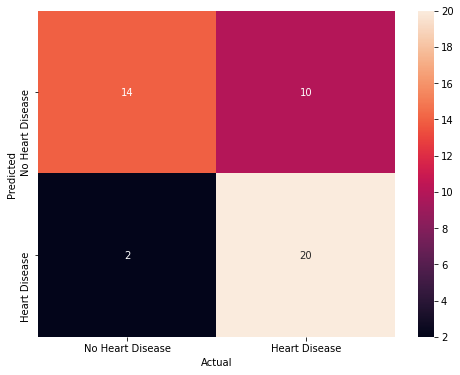

In [48]:
c_mat = confusion_matrix(y_pred, y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["No Heart Disease","Heart Disease"]
c_mat_df.index = ["No Heart Disease","Heart Disease"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

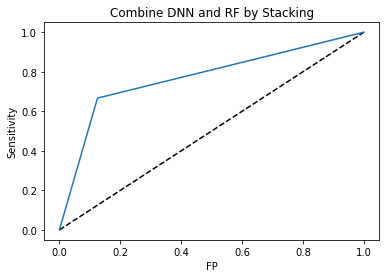

In [49]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
title = "Combine DNN and RF by Stacking"
plt.title(title)
plt.show()

In [50]:
roc_auc_score(y_pred, y_test)

0.7708333333333333

In [51]:
conclusion["StackingClassifier DNN+RF"]=accuracy_score(y_pred, y_test)

#### 2.Voting

In [52]:
x_train_valid,x_test,y_train_valid,y_test=train_test_split(x,y,test_size=0.15)
x_train,x_valid,y_train,y_valid=train_test_split(x_train_valid,y_train_valid,test_size=x_test.shape[0]/x_train_valid.shape[0])
print(x_train.shape, x_valid.shape,x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1) 
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
print(x_train.shape,y_train.shape)

(211, 13) (46, 13) (46, 13)
(211,) (46,) (46,)
(226, 13) (226,)


In [53]:
def create_model():
    model = Sequential()
    model.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [54]:
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
model._estimator_type = "classifier"

In [55]:
voting_test_test_result =dict()
for i in range(1,101,10):
    Voting_test = VotingClassifier(
        estimators=[("dnn",model),
                    ('rf', RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = i))
                   ], 
        voting='soft'
    )
    Voting_test.fit(x_train,y_train)
    y_pred = Voting_test.predict(x_valid)
    voting_test_test_result[i]=accuracy_score(y_valid,y_pred)

In [56]:
voting_result_df = pd.DataFrame(list(voting_test_test_result.items()),columns = ['n_estimators', 'accuracy'])

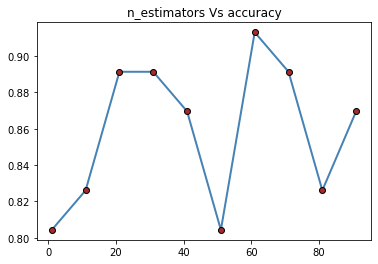

In [57]:
plt.title("n_estimators Vs accuracy")
plt.plot(voting_result_df.n_estimators,voting_result_df.accuracy,linestyle = '-',linewidth = 2, color = 'steelblue',marker = 'o',markersize = 6, markeredgecolor='black', markerfacecolor='brown') 

In [58]:
voting_sorted_dict = sorted(voting_test_test_result.items(), key=lambda x: x[1], reverse=True)

In [59]:
Voting = VotingClassifier(
    estimators=[("dnn",model),
                ('rf', RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators =voting_sorted_dict[0][0]))
               ], 
    voting='soft'
)

In [60]:
Voting.fit(x_train,y_train)

VotingClassifier(estimators=[('dnn',
                              <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000249734C4888>),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     n_estimators=61,
                                                     random_state=0))],
                 voting='soft')

In [61]:
y_pred = Voting.predict(x_test)

In [62]:
accuracy_score(y_pred, y_test)

0.782608695652174

In [63]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.81      0.81      0.81        26

    accuracy                           0.78        46
   macro avg       0.78      0.78      0.78        46
weighted avg       0.78      0.78      0.78        46



Text(50.99999999999999, 0.5, 'Predicted')

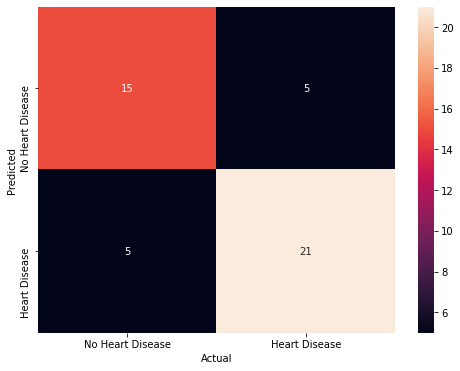

In [64]:
c_mat = confusion_matrix(y_pred, y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["No Heart Disease","Heart Disease"]
c_mat_df.index = ["No Heart Disease","Heart Disease"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

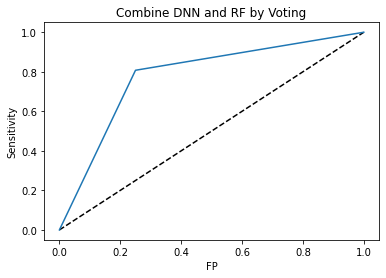

In [65]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
title = "Combine DNN and RF by Voting"
plt.title(title)
plt.show()

In [66]:
roc_auc_score(y_pred, y_test)

0.7788461538461539

In [67]:
conclusion["VotingClassifier DNN+RF"]=accuracy_score(y_pred, y_test)

#### 3. Blending

In [68]:
x_train_valid,x_test,y_train_valid,y_test=train_test_split(x,y,test_size=0.15)
x_train,x_valid,y_train,y_valid=train_test_split(x_train_valid,y_train_valid,test_size=x_test.shape[0]/x_train_valid.shape[0])
print(x_train.shape, x_valid.shape,x_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1) 
x_train, y_train = sm.fit_sample(x_train, y_train.ravel())
print(x_train.shape,y_train.shape)

(211, 13) (46, 13) (46, 13)
(211,) (46,) (46,)
(244, 13) (244,)


In [69]:
model = Sequential()
model.add(Dense(30, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid),epochs=20, batch_size=5)

Epoch 1/20
49/49 [==============================] - 0s 2ms/step - loss: 2.4819 - accuracy: 0.5000 - val_loss: 0.7436 - val_accuracy: 0.4783
Epoch 2/20
49/49 [==============================] - 0s 773us/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6895 - val_accuracy: 0.4783
Epoch 3/20
49/49 [==============================] - 0s 814us/step - loss: 0.6754 - accuracy: 0.5123 - val_loss: 0.6850 - val_accuracy: 0.5000
Epoch 4/20
49/49 [==============================] - 0s 855us/step - loss: 0.6682 - accuracy: 0.5574 - val_loss: 0.6715 - val_accuracy: 0.6304
Epoch 5/20
49/49 [==============================] - 0s 814us/step - loss: 0.6514 - accuracy: 0.6189 - val_loss: 0.6663 - val_accuracy: 0.6522
Epoch 6/20
49/49 [==============================] - 0s 834us/step - loss: 0.6344 - accuracy: 0.6639 - val_loss: 0.6660 - val_accuracy: 0.6087
Epoch 7/20
49/49 [==============================] - 0s 835us/step - loss: 0.6268 - accuracy: 0.6721 - val_loss: 0.6681 - val_accuracy: 0.6304
Epoch 8/

In [71]:
blend_rf = dict()
for i in range(1,101,10):
    rfc_test = RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = i)
    rfc_test.fit(x_train,y_train)
    y_pred = rfc_test.predict(x_valid)
    blend_rf[i]=accuracy_score(y_valid,y_pred)

blend_rf_dict = sorted(blend_rf.items(), key=lambda x: x[1], reverse=True)

In [72]:
rfc_test = RandomForestClassifier(criterion = 'entropy', random_state = 0, n_estimators = blend_rf_dict[0][0])
rfc_test.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=21, random_state=0)

In [73]:
holdout_pred_1=pd.DataFrame(model.predict(x_valid),columns = ["Pre1"])
test_pred_1=pd.DataFrame(model.predict(x_test),columns = ["Pre1"])
holdout_pred_2=pd.DataFrame(model.predict(x_valid),columns = ["Pre2"])
test_pred_2=pd.DataFrame(model.predict(x_test),columns = ["Pre2"])
x_valid=x_valid.reset_index(drop=True)
x_test=x_test.reset_index(drop=True)
y_valid=y_valid.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [74]:
df_val=pd.concat([x_valid, holdout_pred_1,holdout_pred_2],axis=1)
df_test=pd.concat([x_test, test_pred_1,test_pred_2],axis=1)

In [75]:
lr_dict = dict()
for i in range(100,10000,100):
    lr = LogisticRegression(max_iter = i)
    lr.fit(df_val,y_valid)
    y_pred = lr.predict(df_test)
    lr_dict[i]=accuracy_score(y_test,y_pred)

d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_L

In [76]:
lr_dict_df = pd.DataFrame(list(lr_dict.items()),columns = ['max_iter', 'accuracy'])

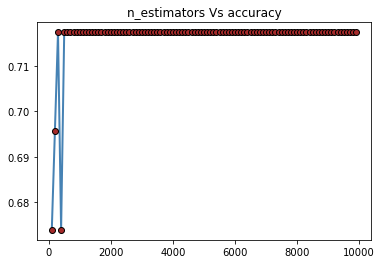

In [77]:
plt.title("n_estimators Vs accuracy")
plt.plot(lr_dict_df.max_iter,lr_dict_df.accuracy,linestyle = '-',linewidth = 2, color = 'steelblue',marker = 'o',markersize = 6, markeredgecolor='black', markerfacecolor='brown')

In [78]:
lr_dict_dict = sorted(lr_dict.items(), key=lambda x: x[1], reverse=True)

In [79]:
lr = LogisticRegression(max_iter = lr_dict_dict [0][0])
lr.fit(df_val,y_valid)

d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=300)

In [80]:
t_pred = lr.predict(df_test)

In [81]:
accuracy_score(y_pred, y_test)

0.717391304347826

In [82]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72        22
           1       0.76      0.67      0.71        24

    accuracy                           0.72        46
   macro avg       0.72      0.72      0.72        46
weighted avg       0.72      0.72      0.72        46



Text(50.99999999999999, 0.5, 'Predicted')

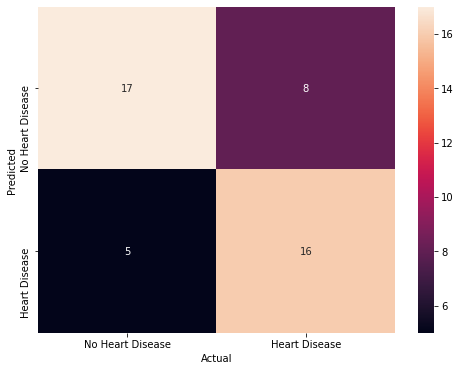

In [83]:
c_mat = confusion_matrix(y_pred, y_test)
c_mat_df = pd.DataFrame(c_mat)
c_mat_df.columns = ["No Heart Disease","Heart Disease"]
c_mat_df.index = ["No Heart Disease","Heart Disease"]
c_mat_df = c_mat_df.T
plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

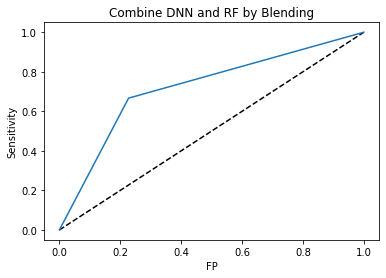

In [84]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
title = "Combine DNN and RF by Blending"
plt.title(title)
plt.show()

In [85]:
roc_auc_score(y_pred, y_test)

0.7196969696969695

In [86]:
conclusion["Blending Classifier DNN+RF"]=accuracy_score(y_pred, y_test)

### 3.Conclusion - Result Comparisons

In [102]:
conclusion

{'RandomForestClassifier()': 0.8478260869565217,
 'DNN - Sequential()': 0.695652186870575,
 'StackingClassifier DNN+RF': 0.7391304347826086,
 'VotingClassifier DNN+RF': 0.782608695652174,
 'Blending Classifier DNN+RF': 0.717391304347826}

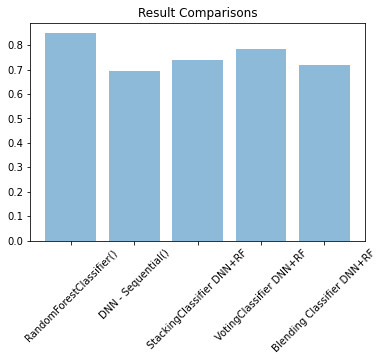

In [103]:
plt.bar(conclusion.keys(), conclusion.values(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.title('Result Comparisons')

plt.show()

In [89]:
"""Tips: If the accurary looks unreasonable, please reload all the function for that model"""

'Tips: If the accurary looks unreasonable, please reload all the function for that model'